<a href="https://colab.research.google.com/github/Natali-bali/TensorFlow_Tutorial/blob/master/08_intro__to_nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to NLP fundamentals in TensorFlow

- Downloading a text dataset
- Visualizing text data
- Converting text into numbers using tokenization
- Turning our tokenized text into an embedding
- Modelling a text dataset
- Starting with a baseline (TF-IDF)
- Building several deep learning text models
- Dense, LSTM, GRU, Conv1D, Transfer learning
- Comparing the performance of each our models
- Combining our models into an ensemble
- Saving and loading a trained model
- Find the most wrong predictions

### Download helper functions and libararies

In [70]:
!wget 'https://raw.githubusercontent.com/Natali-bali/TensorFlow_Tutorial/master/helper_functions.py'

--2021-07-18 18:19:27--  https://raw.githubusercontent.com/Natali-bali/TensorFlow_Tutorial/master/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11016 (11K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.76K  --.-KB/s    in 0s      

2021-07-18 18:19:27 (64.9 MB/s) - ‘helper_functions.py.1’ saved [11016/11016]



In [71]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import re
import random
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Input, Activation, GlobalAveragePooling1D, Flatten, LSTM, GRU, Bidirectional, Conv1D
from helper_functions import plot_confusion_matrix, plot_loss_curves, classes_names, plot_pictures, create_tf_board_callback, unzip_file, compare_historys, walk_through_dir

### Download dataset from Kaggle

We'll be using the Real or Not? datset from Kaggle which contains text-based Tweets about natural disasters.

The Real Tweets are actually about diasters, for example:
'Jetstar and Virgin forced to cancel Bali flights again because of ash from Mount Raung volcano'

The Not Real Tweets are Tweets not about diasters (they can be on anything), for example:
'Education is the most powerful weapon which you can use to change the world.' Nelson #Mandela #quote


In [72]:
!wget "https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip"

unzip_file("nlp_getting_started.zip")

--2021-07-18 18:19:27--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.213.128, 173.194.214.128, 173.194.215.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.213.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip.1’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.006s  

2021-07-18 18:19:27 (97.1 MB/s) - ‘nlp_getting_started.zip.1’ saved [607343/607343]



In [73]:
df_test = pd.read_csv('/content/test.csv')
df_train = pd.read_csv('/content/train.csv')

In [74]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [75]:
df_train.head(30)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [76]:
len(df_test), len(df_train)

(3263, 7613)

In [77]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


### Check the length of our twits

In [80]:
seq_len = [[len(i.split()), k] for i, k in zip(df_train.text, df_train.target)]

In [81]:
df_viz = pd.DataFrame(seq_len, columns = ['number_of_tokens', 'target'])

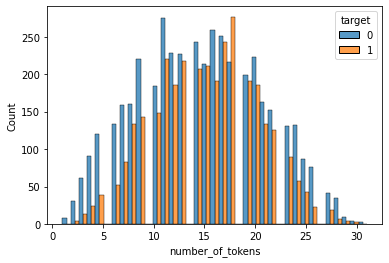

In [82]:
sns.histplot(df_viz, x = 'number_of_tokens', hue = 'target', multiple="dodge")

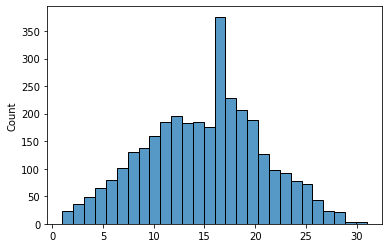

In [83]:
seq_len = [len(i.split()) for i in df_test.text]
sns.histplot(pd.Series(seq_len), )

### Shuffle our data 

In [84]:
df_train = df_train.sample(frac=1, random_state=42)

### Check if dataset is balanced

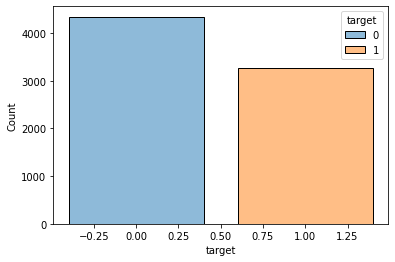

In [85]:
sns.histplot(df_train, x = 'target', hue = 'target', discrete=True, shrink=.8)

### Visualize random tweets


In [86]:
import random
random_index = random.randint(0, len(df_train)-5)
for row in df_train[["text", "target"]][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real disaster)")
  print(f"Text:\n{text}\n")
  print("---\n")

Target: 1 (real disaster)
Text:
#KCA #VoteJKT48ID 12News: UPDATE: A family of 3 has been displaced after fired damaged housed near 90th and Osborn. Fire extinguished no iÛ_

---

Target: 0 (not real disaster)
Text:
@local_arsonist I guess u can say that it's just some shit I was thinking about

---

Target: 0 (not real disaster)
Text:
#hot  Funtenna: hijacking computers to send data as sound waves [Black Hat 2015] http://t.co/G62txymzBv #prebreak #best

---

Target: 1 (real disaster)
Text:
NEMA Ekiti distributed relief materials to affected victims of Rain/Windstorm disaster at Ode-Ekiti in Gbonyin LGA.

---

Target: 1 (real disaster)
Text:
Grace: this is not your first ' storm' you know bicycles fences trees will fly as well as idiots drowning that go by swollen rivers...

---



In [87]:
X_train, X_val, y_train, y_val = train_test_split(df_train.text.to_numpy(), df_train.target.to_numpy(), test_size = 0.1, random_state = 42)

In [88]:
X_test = df_test.text.to_numpy()

In [89]:
X_train[:10], y_train[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object), array([0, 

### Remove links to the accounts, html links, numbers

In [90]:
def remove_links(X):
  X_ = []
  for text in X:
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'http://.+\s*', '', text)
    text = re.sub(r'https://.+\s*', '', text)
    text = re.sub(r'\d+', '', text)
    X_.append(text)
  return X_

In [91]:
X_train = remove_links(X_train)
X_val = remove_links(X_val)
X_test = remove_links(X_test)

In [92]:
X_train[:10]

['  i screamed after hitting tweet',
 'Imagine getting flattened by Kurt Zouma',
 ' #MSGDoingWelfareWorks Green S welfare force ke appx  members har time disaster victim ki help ke liye tyar hai....',
 "   im shaking in fear he's gonna hack the planet",
 'Somehow find you and I collide ',
 '  great times until the bus driver held us hostage in the mall parking lot lmfao',
 'destroy the free fandom honestly',
 'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense ',
 ' Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
 'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery ']

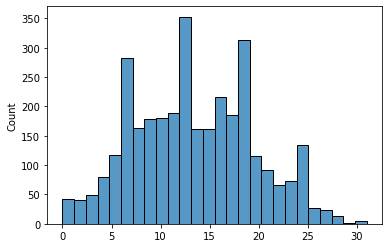

In [93]:
seq_len = [len(i.split()) for i in X_test]
sns.histplot(pd.Series(seq_len))

### Convert text to numbers

In [94]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [95]:
tokens = 30 # Sequence length to pad the outputs to. I choose max length
vocab_length = 10000 # Maximum vocab size

In [96]:
#Create vectorization layer
text_vect = TextVectorization(max_tokens = vocab_length, 
                              standardize = 'lower_and_strip_punctuation', 
                              ngrams = None, 
                              split = 'whitespace',
                              output_sequence_length = tokens, 
                              pad_to_max_tokens=False, 
                              vocabulary=None,
                              output_mode = 'int')

In [97]:
text_vect.adapt(X_train)

In [98]:
text_vect([' great times until the bus driver held us hostage in the mall parking lot lmfao'])

<tf.Tensor: shape=(1, 30), dtype=int64, numpy=
array([[ 184,  238,  290,    2,  355,  860, 1986,   67,  493,    4,    2,
        2717, 2654,  486, 2734,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0]])>

### Get unique words in sentences (vocab)

In [99]:
text_vect.vocabulary_size()

10000

In [100]:
words_in_vocab = text_vect.get_vocabulary()

In [101]:
words_in_vocab[:5]

['', '[UNK]', 'the', 'a', 'in']

In [102]:
words_in_vocab[-5:]

['kebabtahinipickles', 'kdr', 'kcrw', 'kckh', 'kc']

### Create embedding

Turns positive integers (indexes) into dense vectors of fixed size.

https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding

`tf.keras.layers.Embedding(
    input_dim, output_dim, embeddings_initializer='uniform',
    embeddings_regularizer=None, activity_regularizer=None,
    embeddings_constraint=None, mask_zero=False, input_length=None, **kwargs
)`

This layer can only be used as the first layer in a model.

In [103]:
from tensorflow.keras.layers import Embedding

In [104]:
embedding = Embedding(input_dim = vocab_length,
                      output_dim = 128, #better if can divide by 6
                      embeddings_initializer='uniform', 
                      embeddings_regularizer=None, 
                      activity_regularizer=None, 
                      embeddings_constraint=None, 
                      mask_zero = False, 
                      input_length = tokens)

In [105]:
random_tweet = random.choice(X_train)
print(f'Original: {random_tweet}\n')
print(f'Vectorized: {text_vect([random_tweet])}\n')
print(f'Embedded: {embedding(text_vect([random_tweet]))}')

Original: Cop pulls drunk driver to safety SECONDS before his car is hit by train. 

Vectorized: [[2042 2606 1250  860    5 1009 1526  228   75  129    9  231   18  115
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]]

Embedded: [[[-0.00819391 -0.04944763  0.04360486 ...  0.03443612 -0.0379647
   -0.00624881]
  [-0.01250126 -0.04934352 -0.00232862 ...  0.04342916  0.03702369
   -0.03390565]
  [-0.01750424 -0.01120593  0.01293334 ... -0.03632288 -0.01328503
   -0.01161413]
  ...
  [-0.04303074 -0.003202   -0.01064591 ... -0.01452629  0.01022334
    0.00773042]
  [-0.04303074 -0.003202   -0.01064591 ... -0.01452629  0.01022334
    0.00773042]
  [-0.04303074 -0.003202   -0.01064591 ... -0.01452629  0.01022334
    0.00773042]]]


In [106]:
embedding(text_vect([random_tweet])).shape

TensorShape([1, 30, 128])

Now that we've got a way to turn our text data into numbers, we can start to build machine learning models to model it.


To get plenty of practice, we're going to build a series of different models, each as its own experiment. We'll then compare the results of each model and see which one performed best.


More specifically, we'll be building the following:


- Model 0: Naive Bayes (baseline)
- Model 1: Feed-forward neural network (dense model)
- Model 2: LSTM model
- Model 3: GRU model
- Model 4: Bidirectional-LSTM model
- Model 5: 1D Convolutional Neural Network
- Model 6: TensorFlow Hub Pretrained Feature Extractor
- Model 7: Same as model 6 with 10% of training data

### Model 0: Naive Bayes (baseline)

In [107]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_fscore_support

In [108]:
model_0 = Pipeline([('vect', CountVectorizer()),
                    ('tfidf', TfidfTransformer()),
                    ('mnb', MultinomialNB())])

In [109]:
model_0.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('mnb',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [110]:
base_pred = model_0.predict(X_val)

In [111]:
base_val_accuracy = accuracy_score(y_val, base_pred )
base_val_accuracy

0.7965879265091863

In [112]:
base_val_precision = precision_score(y_val, base_pred )
base_val_precision

0.8844621513944223

#### Save results to results_df

In [113]:
results_df = pd.DataFrame(columns = ['num_experiment','model_name', 'accuracy_score', 'precision', 'racall', 'f-1_score'])

In [114]:
def write_result(y_pred, model_name, y_val = y_val):
  global results_df
  #another way
  # precision, racall, f1_score, _ = precision_recall_fscore_support(y_val, y_pred, average = 'weights')
  results_df.loc[len(results_df)] = [len(results_df),
                                     model_name, 
                                     accuracy_score(y_val, y_pred), 
                                     precision_score(y_val, y_pred),
                                     recall_score(y_val, y_pred),
                                     f1_score(y_val, y_pred)
                                     ]

In [115]:
write_result(base_pred, 'base_naive_bayes')

In [116]:
results_df

,num_experiment,model_name,accuracy_score,precision,racall,f-1_score
0,0,base_naive_bayes,0.796588,0.884462,0.637931,0.741235


In [117]:
base_conf_matr = confusion_matrix(y_val, base_pred)

In [118]:
base_conf_matr

array([[385,  29],
       [126, 222]])

### Model1: Feed-forward neural network (dense model)

#### Create Tensorflow Board callback

In [119]:
DIR = 'model_logs'
#create_tf_board_callback()

In [120]:
inputs = Input(shape = (1,), dtype=tf.string)
x = text_vect(inputs)
x = embedding(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
outputs =  Dense(1, activation='sigmoid')(x)
model_1 = Model(inputs, outputs)

In [121]:
model_1.compile(optimizer='adam', metrics='accuracy', loss = 'binary_crossentropy')

In [122]:
model_1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 30)                0         
_________________________________________________________________
embedding (Embedding)        (None, 30, 128)           1280000   
_________________________________________________________________
flatten (Flatten)            (None, 3840)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                245824    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 1,525,889
Trainable params: 1,525,889
Non-trainable params: 0
___________________________________________________

In [123]:
history_1 = model_1.fit(tf.constant(X_train), y_train, 
             epochs = 5,
            validation_data = (tf.constant(X_val), y_val),
            callbacks = create_tf_board_callback(DIR, 'model_1_base_dense'))

Saving TensorBoard log files to model_logs/model_1_base_dense/20210718-181932
Epoch 1/5
215/215 [==============================] - 6s 23ms/step - loss: 0.5475 - accuracy: 0.7224 - val_loss: 0.4964 - val_accuracy: 0.7703
Epoch 2/5
215/215 [==============================] - 4s 20ms/step - loss: 0.2613 - accuracy: 0.9035 - val_loss: 0.5794 - val_accuracy: 0.7677
Epoch 3/5
215/215 [==============================] - 4s 20ms/step - loss: 0.1230 - accuracy: 0.9615 - val_loss: 0.6133 - val_accuracy: 0.7651
Epoch 4/5
215/215 [==============================] - 4s 20ms/step - loss: 0.0927 - accuracy: 0.9673 - val_loss: 0.6663 - val_accuracy: 0.7598
Epoch 5/5
215/215 [==============================] - 4s 20ms/step - loss: 0.0756 - accuracy: 0.9723 - val_loss: 0.7083 - val_accuracy: 0.7546


In [124]:
prob_1 = model_1.predict(tf.constant(X_val))

In [125]:
prob_1.shape

(762, 1)

In [126]:
pred_1 = tf.round(tf.squeeze(prob_1))

In [127]:
pred_1[:10], y_val[:10]

(<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>,
 array([0, 0, 1, 1, 1, 1, 1, 1, 1, 0]))

In [128]:
write_result(pred_1, 'base_dense_model_1')

In [129]:
results_df

,num_experiment,model_name,accuracy_score,precision,racall,f-1_score
0,0,base_naive_bayes,0.796588,0.884462,0.637931,0.741235
1,1,base_dense_model_1,0.754593,0.778547,0.646552,0.706436


In [130]:
model1_conf_matr = confusion_matrix(y_val, pred_1)
model1_conf_matr

array([[350,  64],
       [123, 225]])

In [131]:
base_conf_matr

array([[385,  29],
       [126, 222]])

#### Build base model as in tutorial: add GlobalAveragePooling1D() and remove Dense(128) 5 epochs

In [132]:
from tensorflow.keras import backend as K

In [133]:
K.clear_session()

In [134]:
#I replace Flatten layer to GAP, run for 5 epochs 
inputs = Input(shape = (1,), dtype=tf.string)
x = text_vect(inputs)
x = embedding(x)
x = GlobalAveragePooling1D()(x) 
x = Dense(64, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)

In [135]:
model_1_2 = Model(inputs, outputs)

In [136]:
model_1_2.compile(optimizer='adam', metrics='accuracy', loss = 'binary_crossentropy')

In [137]:
model_1_2.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 30)                0         
_________________________________________________________________
embedding (Embedding)        (None, 30, 128)           1280000   
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 1,288,321
Trainable params: 1,288,321
Non-trainable params: 0
___________________________________________________

In [138]:
history_1_2 = model_1_2.fit(tf.constant(X_train), y_train,
                        epochs = 5,
                        validation_data = (tf.constant(X_val), y_val),
                        callbacks = create_tf_board_callback(DIR, 'model_1_2_dense'))

Saving TensorBoard log files to model_logs/model_1_2_dense/20210718-182014
Epoch 1/5
215/215 [==============================] - 5s 20ms/step - loss: 0.4841 - accuracy: 0.8066 - val_loss: 0.4675 - val_accuracy: 0.7953
Epoch 2/5
215/215 [==============================] - 4s 18ms/step - loss: 0.2855 - accuracy: 0.8878 - val_loss: 0.4873 - val_accuracy: 0.7900
Epoch 3/5
215/215 [==============================] - 4s 18ms/step - loss: 0.2116 - accuracy: 0.9199 - val_loss: 0.5476 - val_accuracy: 0.7808
Epoch 4/5
215/215 [==============================] - 4s 18ms/step - loss: 0.1628 - accuracy: 0.9394 - val_loss: 0.6147 - val_accuracy: 0.7585
Epoch 5/5
215/215 [==============================] - 4s 17ms/step - loss: 0.1336 - accuracy: 0.9501 - val_loss: 0.6731 - val_accuracy: 0.7664


In [139]:
prob_1_2 = model_1_2.predict(tf.constant(X_val))

In [140]:
prob_1_2.shape

(762, 1)

In [141]:
pred_1_2 = np.round(prob_1_2).flatten()

In [142]:
pred_1_2[:10], y_val[:10]

(array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32),
 array([0, 0, 1, 1, 1, 1, 1, 1, 1, 0]))

In [143]:
write_result(pred_1_2, 'simple_dense_model_1_2')

In [144]:
results_df

,num_experiment,model_name,accuracy_score,precision,racall,f-1_score
0,0,base_naive_bayes,0.796588,0.884462,0.637931,0.741235
1,1,base_dense_model_1,0.754593,0.778547,0.646552,0.706436
2,2,simple_dense_model_1_2,0.766404,0.760736,0.712644,0.735905


In [145]:
model1_2_conf_matr = confusion_matrix(y_val, pred_1_2)
model1_2_conf_matr

array([[336,  78],
       [100, 248]])

In [146]:
base_conf_matr

array([[385,  29],
       [126, 222]])

### Visualise learned Embedding

In [147]:
model_1_2.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 30)                0         
_________________________________________________________________
embedding (Embedding)        (None, 30, 128)           1280000   
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 1,288,321
Trainable params: 1,288,321
Non-trainable params: 0
___________________________________________________

In [148]:
# Get the vocabulary from the text vectorization layer
words_in_vocab = text_vect.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'i', 'and', 'is'])

In [149]:
embed_weights = model_1_2.get_layer('embedding').get_weights()[0]

In [150]:
embed_weights

array([[-0.02608325,  0.00899968, -0.03775078, ..., -0.05280675,
         0.00655089, -0.00026329],
       [-0.02868187, -0.02993948, -0.0846602 , ..., -0.0738945 ,
        -0.01157874, -0.00718066],
       [-0.09699412, -0.04173055, -0.05894978, ..., -0.02827577,
        -0.03849116, -0.01960803],
       ...,
       [ 0.02420943, -0.09614508, -0.02678978, ...,  0.05754858,
        -0.07618024, -0.06824715],
       [ 0.02830743, -0.08649892,  0.02320611, ...,  0.04361049,
        -0.07540054, -0.08066202],
       [-0.03301301,  0.08612832, -0.05993679, ..., -0.02410746,
         0.00147512, -0.00212138]], dtype=float32)

Now we've got these two objects, we can use the Embedding Projector tool to visualize our embedding.

To use the Embedding Projector tool, we need two files:
- The embedding vectors (same as embedding weights).
- The meta data of the embedding vectors (the words they represent - our vocabulary).

Right now, we've got of these files as Python objects. To download them to file, we're going to use the code example available on the TensorFlow word embeddings tutorial page.

https://www.tensorflow.org/tutorials/text/word_embeddings#retrieve_the_trained_word_embeddings_and_save_them_to_disk

In [151]:
import io
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(words_in_vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = embed_weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

In [152]:
try:
  from google.colab import files
  files.download('vectors.tsv')
  files.download('metadata.tsv')
except Exception:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Recurrent Neural Networks

The premise of an RNN is simple: use information from the past to help you with the future (this is where the term recurrent comes from). In other words, take an input (X) and compute an output (y) based on all previous inputs.

This concept is especially helpful when dealing with sequences such as passages of natural language text (such as our Tweets).
For example, when you read this sentence, you take into context the previous words when deciphering the meaning of the current word.

When an RNN looks at a sequence of text (already in numerical form), the patterns it learns are continually updated based on the order of the sequence.

For a simple example, take two sentences:
Massive earthquake last week, no?
No massive earthquake last week.
Both contain exactly the same words but have different meaning. The order of the words determines the meaning (one could argue punctuation marks also dictate the meaning but for simplicity sake, let's stay focused on the words).

Recurrent neural networks can be used for a number of sequence-based problems:
- One to one: one input, one output, such as image classification.
- One to many: one input, many outputs, such as image captioning (image input, a sequence of text as caption output).
- Many to one: many inputs, one outputs, such as text classification (classifying a Tweet as real diaster or not real diaster).
- Many to many: many inputs, many outputs, such as machine translation (translating English to Spanish) or speech to text (audio wave as input, text as output).

When you come across RNN's in the wild, you'll most likely come across variants of the following:
- Long short-term memory cells (LSTMs).
- Gated recurrent units (GRUs).
- Bidirectional RNN's (passes forward and backward along a sequence, left to right and right to left).

### Model2 LSTM
`Input (text) -> Tokenize -> Embedding -> Layers -> Output (label probability)
`

In [153]:
K.clear_session()

In [154]:
inputs = Input(shape = (1,), dtype = tf.string)
x = text_vect(inputs)
x = embedding(x)
x = LSTM(units = 64, return_sequences=True)(x)
x = LSTM(64)(x)
x = Dense(64, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)

In [155]:
model_2 = Model(inputs, outputs)

In [156]:
model_2.compile(optimizer='adam', metrics='accuracy', loss = 'binary_crossentropy')

In [157]:
model_2.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 30)                0         
_________________________________________________________________
embedding (Embedding)        (None, 30, 128)           1280000   
_________________________________________________________________
lstm (LSTM)                  (None, 30, 64)            49408     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65    

In [158]:
history_2 = model_2.fit(tf.constant(X_train), y_train,
                        epochs = 5,
                        validation_data = (tf.constant(X_val), y_val),
                        callbacks = create_tf_board_callback(DIR, 'model_2_LSTM'))

Saving TensorBoard log files to model_logs/model_2_LSTM/20210718-182037
Epoch 1/5
215/215 [==============================] - 18s 66ms/step - loss: 0.1967 - accuracy: 0.9296 - val_loss: 0.8176 - val_accuracy: 0.7730
Epoch 2/5
215/215 [==============================] - 13s 58ms/step - loss: 0.1152 - accuracy: 0.9590 - val_loss: 0.8235 - val_accuracy: 0.7756
Epoch 3/5
215/215 [==============================] - 13s 59ms/step - loss: 0.0991 - accuracy: 0.9638 - val_loss: 0.8395 - val_accuracy: 0.7612
Epoch 4/5
215/215 [==============================] - 13s 59ms/step - loss: 0.0936 - accuracy: 0.9663 - val_loss: 0.8935 - val_accuracy: 0.7690
Epoch 5/5
215/215 [==============================] - 13s 58ms/step - loss: 0.1117 - accuracy: 0.9602 - val_loss: 0.9966 - val_accuracy: 0.7730


In [159]:
prob_2 = model_2.predict(tf.constant(X_val))

In [160]:
prob_2.shape

(762, 1)

In [161]:
pred_2 = np.round(prob_2).flatten()

In [162]:
pred_2[:10], y_val[:10]

(array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32),
 array([0, 0, 1, 1, 1, 1, 1, 1, 1, 0]))

In [163]:
write_result(pred_2, 'LSTM_model_2')

In [164]:
results_df

,num_experiment,model_name,accuracy_score,precision,racall,f-1_score
0,0,base_naive_bayes,0.796588,0.884462,0.637931,0.741235
1,1,base_dense_model_1,0.754593,0.778547,0.646552,0.706436
2,2,simple_dense_model_1_2,0.766404,0.760736,0.712644,0.735905
3,3,LSTM_model_2,0.772966,0.779553,0.701149,0.738275


In [165]:
model2_conf_matr = confusion_matrix(y_val, pred_2)
model2_conf_matr

array([[345,  69],
       [104, 244]])

In [166]:
base_conf_matr

array([[385,  29],
       [126, 222]])

### Model3 GRU
The GRU cell has similar features to an LSTM cell but has less parameters.


In [167]:
inputs = Input(shape = (1,), dtype = 'string')
x = text_vect(inputs)
x = embedding(x)
x = GRU(64, return_sequences=True)(x)
x = LSTM(64, return_sequences = True)(x)
x = GRU(64)(x)
x = Dense(64, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)

In [168]:
model_3 = Model(inputs, outputs)

In [169]:
model_3.compile(optimizer='adam', metrics='accuracy', loss = 'binary_crossentropy')
model_3.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 30)                0         
_________________________________________________________________
embedding (Embedding)        (None, 30, 128)           1280000   
_________________________________________________________________
gru (GRU)                    (None, 30, 64)            37248     
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 64)            33024     
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                24960     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160

In [170]:
history_3 = model_3.fit(tf.constant(X_train), y_train, epochs = 5,
                        validation_data = (tf.constant(X_val), y_val),
                        callbacks = create_tf_board_callback(DIR, 'model_3_GRU'))

Saving TensorBoard log files to model_logs/model_3_GRU/20210718-182205
Epoch 1/5
215/215 [==============================] - 24s 82ms/step - loss: 0.1673 - accuracy: 0.9323 - val_loss: 0.7530 - val_accuracy: 0.7664
Epoch 2/5
215/215 [==============================] - 16s 72ms/step - loss: 0.0877 - accuracy: 0.9658 - val_loss: 1.0996 - val_accuracy: 0.7638
Epoch 3/5
215/215 [==============================] - 16s 73ms/step - loss: 0.0752 - accuracy: 0.9707 - val_loss: 1.1885 - val_accuracy: 0.7598
Epoch 4/5
215/215 [==============================] - 16s 73ms/step - loss: 0.0721 - accuracy: 0.9714 - val_loss: 1.1585 - val_accuracy: 0.7651
Epoch 5/5
215/215 [==============================] - 16s 74ms/step - loss: 0.0626 - accuracy: 0.9730 - val_loss: 1.3456 - val_accuracy: 0.7651


In [171]:
prob_3 = model_3.predict(tf.constant(X_val))

In [172]:
prob_3.shape

(762, 1)

In [173]:
pred_3 = np.round(prob_3).flatten()

In [174]:
pred_3[:10], y_val[:10]

(array([0., 0., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32),
 array([0, 0, 1, 1, 1, 1, 1, 1, 1, 0]))

In [175]:
write_result(pred_3, 'GRU_model_3')

In [176]:
results_df

,num_experiment,model_name,accuracy_score,precision,racall,f-1_score
0,0,base_naive_bayes,0.796588,0.884462,0.637931,0.741235
1,1,base_dense_model_1,0.754593,0.778547,0.646552,0.706436
2,2,simple_dense_model_1_2,0.766404,0.760736,0.712644,0.735905
3,3,LSTM_model_2,0.772966,0.779553,0.701149,0.738275
4,4,GRU_model_3,0.765092,0.807273,0.637931,0.712681


In [177]:
model3_conf_matr = confusion_matrix(y_val, pred_3)
model3_conf_matr

array([[361,  53],
       [126, 222]])

In [178]:
base_conf_matr

array([[385,  29],
       [126, 222]])

### Model4 Bidirectional LSTM(RNN)

A standard RNN will process a sequence from left to right, where as a bidirectional RNN will process the sequence from left to right and then again from right to left.

In [179]:
inputs = Input(shape = (1,), dtype='string')
x = text_vect(inputs)
x = embedding(x)
x = Bidirectional(LSTM(64, return_sequences = True))(x)
x = Bidirectional(GRU(64))(x)
x = Dense(64)(x)
outputs = Dense(1, activation='sigmoid')(x)

In [180]:
model_4 = Model(inputs, outputs)

In [181]:
model_4.compile(optimizer='adam', metrics='accuracy', loss = 'binary_crossentropy')


In [182]:
model_4.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 30)                0         
_________________________________________________________________
embedding (Embedding)        (None, 30, 128)           1280000   
_________________________________________________________________
bidirectional (Bidirectional (None, 30, 128)           98816     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               74496     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65  

In [183]:
history_4 = model_4.fit(tf.constant(X_train), y_train, epochs = 5,
                        validation_data = (tf.constant(X_val), y_val),
                        callbacks = create_tf_board_callback(DIR, 'model_4_bidirectional'))

Saving TensorBoard log files to model_logs/model_4_bidirectional/20210718-182334
Epoch 1/5
215/215 [==============================] - 29s 101ms/step - loss: 0.1156 - accuracy: 0.9548 - val_loss: 0.9966 - val_accuracy: 0.7664
Epoch 2/5
215/215 [==============================] - 19s 90ms/step - loss: 0.0638 - accuracy: 0.9705 - val_loss: 1.1873 - val_accuracy: 0.7572
Epoch 3/5
215/215 [==============================] - 20s 91ms/step - loss: 0.0574 - accuracy: 0.9743 - val_loss: 1.9377 - val_accuracy: 0.7612
Epoch 4/5
215/215 [==============================] - 21s 98ms/step - loss: 0.0592 - accuracy: 0.9727 - val_loss: 1.8461 - val_accuracy: 0.7559
Epoch 5/5
215/215 [==============================] - 20s 92ms/step - loss: 0.0480 - accuracy: 0.9724 - val_loss: 2.0455 - val_accuracy: 0.7559


In [184]:
prob_4 = model_4.predict(tf.constant(X_val))

In [185]:
pred_4 = np.round(prob_4).flatten()

In [186]:
write_result(pred_4, 'Bidirectional_model_4')

In [187]:
results_df

,num_experiment,model_name,accuracy_score,precision,racall,f-1_score
0,0,base_naive_bayes,0.796588,0.884462,0.637931,0.741235
1,1,base_dense_model_1,0.754593,0.778547,0.646552,0.706436
2,2,simple_dense_model_1_2,0.766404,0.760736,0.712644,0.735905
3,3,LSTM_model_2,0.772966,0.779553,0.701149,0.738275
4,4,GRU_model_3,0.765092,0.807273,0.637931,0.712681
5,5,Bidirectional_model_4,0.755906,0.785211,0.640805,0.705696


In [188]:
model4_conf_matr = confusion_matrix(y_val, pred_4)
model4_conf_matr

array([[353,  61],
       [125, 223]])

In [189]:
base_conf_matr

array([[385,  29],
       [126, 222]])

### Model 5 1D Convolutional Neural Network

In [190]:
K.clear_session()

In [191]:
inputs = Input((1,), dtype = 'string')
x = text_vect(inputs)
x = embedding(x)
x = Conv1D(32, 3, activation='relu')(x)
x = GlobalAveragePooling1D()(x)
x = Dense(64, activation='relu')(x)
outputs = Dense(1, activation= 'sigmoid')(x)

In [192]:
model_5 = Model(inputs, outputs)

In [193]:
model_5.compile(optimizer='adam', metrics='accuracy', loss = 'binary_crossentropy')

In [194]:
model_5.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 30)                0         
_________________________________________________________________
embedding (Embedding)        (None, 30, 128)           1280000   
_________________________________________________________________
conv1d (Conv1D)              (None, 28, 32)            12320     
_________________________________________________________________
global_average_pooling1d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                2112      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65    

In [195]:
history_5 = model_5.fit(tf.constant(X_train), y_train, epochs = 5,
                        validation_data = (tf.constant(X_val), y_val),
                        callbacks = create_tf_board_callback(DIR, 'model_5_Conv1D'))

Saving TensorBoard log files to model_logs/model_5_Conv1D/20210718-182605
Epoch 1/5
215/215 [==============================] - 6s 24ms/step - loss: 0.2184 - accuracy: 0.9204 - val_loss: 0.9148 - val_accuracy: 0.7677
Epoch 2/5
215/215 [==============================] - 5s 22ms/step - loss: 0.0841 - accuracy: 0.9685 - val_loss: 1.0043 - val_accuracy: 0.7454
Epoch 3/5
215/215 [==============================] - 5s 22ms/step - loss: 0.0706 - accuracy: 0.9707 - val_loss: 1.1418 - val_accuracy: 0.7520
Epoch 4/5
215/215 [==============================] - 5s 22ms/step - loss: 0.0648 - accuracy: 0.9710 - val_loss: 1.2668 - val_accuracy: 0.7559
Epoch 5/5
215/215 [==============================] - 5s 23ms/step - loss: 0.0606 - accuracy: 0.9727 - val_loss: 1.3218 - val_accuracy: 0.7507


In [196]:
prob_5 = model_5.predict(tf.constant(X_val))

In [197]:
pred_5 = np.round(prob_5).flatten()

In [198]:
write_result(pred_5, 'Conv1D_model_5')

In [199]:
results_df

,num_experiment,model_name,accuracy_score,precision,racall,f-1_score
0,0,base_naive_bayes,0.796588,0.884462,0.637931,0.741235
1,1,base_dense_model_1,0.754593,0.778547,0.646552,0.706436
2,2,simple_dense_model_1_2,0.766404,0.760736,0.712644,0.735905
3,3,LSTM_model_2,0.772966,0.779553,0.701149,0.738275
4,4,GRU_model_3,0.765092,0.807273,0.637931,0.712681
5,5,Bidirectional_model_4,0.755906,0.785211,0.640805,0.705696
6,6,Conv1D_model_5,0.750656,0.754839,0.672414,0.711246


In [200]:
model5_conf_matr = confusion_matrix(y_val, pred_5)
model5_conf_matr

array([[338,  76],
       [114, 234]])

In [201]:
base_conf_matr

array([[385,  29],
       [126, 222]])

Our Deep Learning models didn't beat base model. We will use transfer learning to improve those results!

### Model6 TensorFlow Hub Pretrained Feature Extractor
We will use USE(universal sentence encoder) feauture extractor
https://tfhub.dev/google/collections/universal-sentence-encoder/1

In [202]:
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [203]:
embeddings = embed([
    "The quick brown fox jumps over the lazy dog.",
    "I am a sentence for which I would like to get its embedding"])

print(embeddings)

tf.Tensor(
[[-0.03133018 -0.06338634 -0.01607502 ... -0.03242778 -0.04575741
   0.05370456]
 [ 0.05080861 -0.01652428  0.01573781 ...  0.00976659  0.03170123
   0.01788119]], shape=(2, 512), dtype=float32)


In [204]:
use_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                           input_shape = [],
                           dtype = tf.string,
                           trainable = False)

In [205]:
K.clear_session()

In [206]:
model_6 = Sequential([use_layer,
                     Dense(128, activation='relu'),
                     Dense(64, activation='relu'),
                     Dense(1, activation='sigmoid')])

In [207]:
model_6.compile(optimizer='adam', metrics = 'accuracy', loss = 'binary_crossentropy')

In [208]:
model_6.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 512)               256797824 
_________________________________________________________________
dense (Dense)                (None, 128)               65664     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 256,871,809
Trainable params: 73,985
Non-trainable params: 256,797,824
_________________________________________________________________


In [209]:
history_6 = model_6.fit(tf.constant(X_train), y_train, epochs = 5,
                        validation_data = (tf.constant(X_val), y_val),
                        callbacks = create_tf_board_callback(DIR, 'USE_model_6'))

Saving TensorBoard log files to model_logs/USE_model_6/20210718-182658
Epoch 1/5
215/215 [==============================] - 8s 27ms/step - loss: 0.4754 - accuracy: 0.7894 - val_loss: 0.4489 - val_accuracy: 0.7966
Epoch 2/5
215/215 [==============================] - 2s 11ms/step - loss: 0.3977 - accuracy: 0.8256 - val_loss: 0.4356 - val_accuracy: 0.7940
Epoch 3/5
215/215 [==============================] - 3s 12ms/step - loss: 0.3701 - accuracy: 0.8428 - val_loss: 0.4314 - val_accuracy: 0.8097
Epoch 4/5
215/215 [==============================] - 2s 11ms/step - loss: 0.3390 - accuracy: 0.8593 - val_loss: 0.4492 - val_accuracy: 0.8058
Epoch 5/5
215/215 [==============================] - 2s 12ms/step - loss: 0.3020 - accuracy: 0.8767 - val_loss: 0.4504 - val_accuracy: 0.8123


In [210]:
prob_6 = model_6.predict(tf.constant(X_val))

In [211]:
pred_6 = np.round(prob_6).flatten()

In [212]:
write_result(pred_6, 'USE_model_6')

In [213]:
results_df

,num_experiment,model_name,accuracy_score,precision,racall,f-1_score
0,0,base_naive_bayes,0.796588,0.884462,0.637931,0.741235
1,1,base_dense_model_1,0.754593,0.778547,0.646552,0.706436
2,2,simple_dense_model_1_2,0.766404,0.760736,0.712644,0.735905
3,3,LSTM_model_2,0.772966,0.779553,0.701149,0.738275
4,4,GRU_model_3,0.765092,0.807273,0.637931,0.712681
5,5,Bidirectional_model_4,0.755906,0.785211,0.640805,0.705696
6,6,Conv1D_model_5,0.750656,0.754839,0.672414,0.711246
7,7,USE_model_6,0.812336,0.870036,0.692529,0.771200


In [214]:
model6_conf_matr = confusion_matrix(y_val, pred_6)
model6_conf_matr

array([[378,  36],
       [107, 241]])

In [215]:
base_conf_matr

array([[385,  29],
       [126, 222]])

### Try transfer learning with 10% data
Its useful for small datasets in real projects

In [216]:
len(X_train), len(X_val)

(6851, 762)

In [217]:
X_train_10 = X_train[:int(len(X_train)*0.1)]
y_train_10 = y_train[:int(len(X_train)*0.1)]

In [218]:
len(X_train_10), len(y_train_10)

(685, 685)

In [219]:
model_7 = Sequential([use_layer,
                     Dense(64, activation='relu'),
                     Dense(1, activation='sigmoid')])

In [220]:
model_7.compile(optimizer='adam', metrics = 'accuracy', loss = 'binary_crossentropy')

In [221]:
model_7.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 512)               256797824 
_________________________________________________________________
dense_3 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [222]:
history_7 = model_7.fit(tf.constant(X_train_10), y_train_10, epochs = 5,
                        validation_data = (tf.constant(X_val), y_val),
                        callbacks = create_tf_board_callback(DIR, 'USE_model_7_10%'))

Saving TensorBoard log files to model_logs/USE_model_7_10%/20210718-182718
Epoch 1/5
22/22 [==============================] - 3s 70ms/step - loss: 0.6732 - accuracy: 0.6818 - val_loss: 0.6499 - val_accuracy: 0.7362
Epoch 2/5
22/22 [==============================] - 0s 19ms/step - loss: 0.6063 - accuracy: 0.8161 - val_loss: 0.5980 - val_accuracy: 0.7572
Epoch 3/5
22/22 [==============================] - 0s 20ms/step - loss: 0.5349 - accuracy: 0.8248 - val_loss: 0.5481 - val_accuracy: 0.7625
Epoch 4/5
22/22 [==============================] - 1s 25ms/step - loss: 0.4715 - accuracy: 0.8263 - val_loss: 0.5132 - val_accuracy: 0.7612
Epoch 5/5
22/22 [==============================] - 1s 25ms/step - loss: 0.4303 - accuracy: 0.8234 - val_loss: 0.5012 - val_accuracy: 0.7677


In [223]:
prob_7 = model_7.predict(tf.constant(X_val))

In [224]:
pred_7 = np.round(prob_7).flatten()

In [225]:
write_result(pred_7, 'USE_10%_model_7')

In [226]:
results_df

,num_experiment,model_name,accuracy_score,precision,racall,f-1_score
0,0,base_naive_bayes,0.796588,0.884462,0.637931,0.741235
1,1,base_dense_model_1,0.754593,0.778547,0.646552,0.706436
2,2,simple_dense_model_1_2,0.766404,0.760736,0.712644,0.735905
3,3,LSTM_model_2,0.772966,0.779553,0.701149,0.738275
4,4,GRU_model_3,0.765092,0.807273,0.637931,0.712681
5,5,Bidirectional_model_4,0.755906,0.785211,0.640805,0.705696
6,6,Conv1D_model_5,0.750656,0.754839,0.672414,0.711246
7,7,USE_model_6,0.812336,0.870036,0.692529,0.771200
8,8,USE_10%_model_7,0.767717,0.771429,0.698276,0.733032


In [227]:
model7_conf_matr = confusion_matrix(y_val, pred_7)
model7_conf_matr

array([[342,  72],
       [105, 243]])

In [228]:
base_conf_matr

array([[385,  29],
       [126, 222]])

Try same model with same dataset with more layers and epochs

In [229]:
model_7_2 = Sequential([use_layer,
                     Dense(128, activation='relu'),
                     Dense(64, activation='relu'),
                     Dense(1, activation='sigmoid')])

In [230]:
model_7_2.compile(optimizer='adam', metrics = 'accuracy', loss = 'binary_crossentropy')

In [231]:
model_7_2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 512)               256797824 
_________________________________________________________________
dense_5 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_6 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 256,871,809
Trainable params: 73,985
Non-trainable params: 256,797,824
_________________________________________________________________


In [232]:
history_7_2 = model_7_2.fit(tf.constant(X_train_10), y_train_10, epochs = 25,
                        validation_data = (tf.constant(X_val), y_val),
                        callbacks = create_tf_board_callback(DIR, 'USE_model_7_2_10%'))

Saving TensorBoard log files to model_logs/USE_model_7_2_10%/20210718-182725
Epoch 1/25
22/22 [==============================] - 3s 75ms/step - loss: 0.6733 - accuracy: 0.6526 - val_loss: 0.6440 - val_accuracy: 0.6772
Epoch 2/25
22/22 [==============================] - 1s 26ms/step - loss: 0.5589 - accuracy: 0.7956 - val_loss: 0.5350 - val_accuracy: 0.7677
Epoch 3/25
22/22 [==============================] - 1s 26ms/step - loss: 0.4292 - accuracy: 0.8219 - val_loss: 0.5033 - val_accuracy: 0.7612
Epoch 4/25
22/22 [==============================] - 0s 21ms/step - loss: 0.3486 - accuracy: 0.8496 - val_loss: 0.5228 - val_accuracy: 0.7638
Epoch 5/25
22/22 [==============================] - 0s 21ms/step - loss: 0.2924 - accuracy: 0.8891 - val_loss: 0.5323 - val_accuracy: 0.7612
Epoch 6/25
22/22 [==============================] - 0s 21ms/step - loss: 0.2487 - accuracy: 0.9197 - val_loss: 0.5824 - val_accuracy: 0.7533
Epoch 7/25
22/22 [==============================] - 1s 25ms/step - loss: 0.20

In [233]:
prob_7_2 = model_7_2.predict(tf.constant(X_val))

In [234]:
pred_7_2 = np.round(prob_7_2).flatten()

In [235]:
write_result(pred_7_2, 'USE_10%_model_7_2')

In [236]:
results_df

,num_experiment,model_name,accuracy_score,precision,racall,f-1_score
0,0,base_naive_bayes,0.796588,0.884462,0.637931,0.741235
1,1,base_dense_model_1,0.754593,0.778547,0.646552,0.706436
2,2,simple_dense_model_1_2,0.766404,0.760736,0.712644,0.735905
3,3,LSTM_model_2,0.772966,0.779553,0.701149,0.738275
4,4,GRU_model_3,0.765092,0.807273,0.637931,0.712681
5,5,Bidirectional_model_4,0.755906,0.785211,0.640805,0.705696
6,6,Conv1D_model_5,0.750656,0.754839,0.672414,0.711246
7,7,USE_model_6,0.812336,0.870036,0.692529,0.771200
8,8,USE_10%_model_7,0.767717,0.771429,0.698276,0.733032
9,9,USE_10%_model_7_2,0.734908,0.712209,0.704023,0.708092


In [237]:
results_df = results_df.rename(columns = {'racall':'recall'})

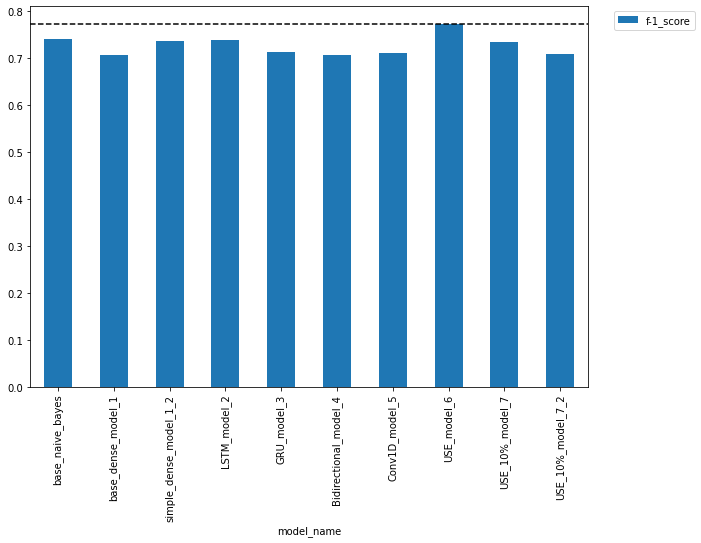

In [238]:
ax = results_df.plot('model_name', ['f-1_score'], kind = 'bar', figsize = (10,7))
ax.hlines(results_df['f-1_score'].max(), -0.5, 10, linestyles='dashed')
ax.legend(bbox_to_anchor = (1.2,1.0))

In [239]:
!tensorboard dev upload --logdir /content/model_logs --name 'NLP modeling experiments' --one_shot

2021-07-18 18:27:43.776456: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

/content/model_logs

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) No


https://tensorboard.dev/experiment/AX7qWZ3mTyWnr1YEco5MtQ/#scalars&runSelectionState=eyJVU0VfbW9kZWxfNi8yMDIxMDcxOC0xNDQ4MDUvdHJhaW4iOnRydWUsIlVTRV9tb2RlbF82LzIwMjEwNzE4LTE1MTQwMS90cmFpbiI6dHJ1ZSwiVVNFX21vZGVsXzYvMjAyMTA3MTgtMTUxNTQzL3RyYWluIjp0cnVlLCJVU0VfbW9kZWxfNi8yMDIxMDcxOC0xNTE2MTgvdHJhaW4iOnRydWUsIlVTRV9tb2RlbF82LzIwMjEwNzE4LTE1MTcyOS90cmFpbiI6dHJ1ZSwiVVNFX21vZGVsXzdfMTAlLzIwMjEwNzE4LTE0NDgyOS90cmFpbiI6dHJ1ZSwiVVNFX21vZGVsXzdfMl8xMCUvMjAyMTA3MTgtMTQ0ODM2L3RyYWluIjp0cnVlLCJtb2RlbF8xLzIwMjEwNzE4LTE0NDQwMy90cmFpbiI6dHJ1ZSwibW9kZWxfMV8yLzIwMjEwNzE4LTE0NDQyNS90cmFpbiI6dHJ1ZSwibW9kZWxfMi8yMDIxMDcxOC0xNDQ0NDgvdHJhaW4iOnRydWUsIm1vZGVsXzMvMjAyMTA3MTgtMTQ0NTE4L3RyYWluIjp0cnVlLCJtb2RlbF80LzIwMjEwNzE4LTE0NDU0OC90cmFpbiI6dHJ1ZX0%3D

### Save and load model
1. hdf5 format
2.save_model format

!NOTE dont forget to add custom object

In [240]:
model_6.save('USE_model.h5')

In [241]:
loaded_model_6 = tf.keras.models.load_model('USE_model.h5', custom_objects={'KerasLayer': hub.KerasLayer})

In [242]:
model_6.save('USE_model') #Saves to folder

INFO:tensorflow:Assets written to: USE_model/assets


INFO:tensorflow:Assets written to: USE_model/assets


In [243]:
loaded_model_6_save_model_format = tf.keras.models.load_model('USE_model')

### Check the most wrong predictions

In [244]:
probs = loaded_model_6_save_model_format.predict(tf.constant(X_val))

In [245]:
probs.flatten()[:10]

array([0.06435454, 0.8745087 , 0.99946606, 0.21497262, 0.4561406 ,
       0.96976537, 0.9936009 , 0.9988649 , 0.9956289 , 0.09337512],
      dtype=float32)

In [246]:
preds = np.round(probs).flatten()

In [247]:
preds[:10]

array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)

In [248]:
y_val[:10]

array([0, 0, 1, 1, 1, 1, 1, 1, 1, 0])

In [249]:
df = pd.DataFrame.from_dict({'probs':probs.flatten(), 'preds':preds, 'true_val': y_val, 'tweets': X_val})

In [250]:
df

,probs,preds,true_val,tweets
0,0.064355,0.0,0,DFR EP Monthly Meltdown - On Dnbheaven ..
1,0.874509,1.0,0,FedEx no longer to transport bioterror germs i...
2,0.999466,1.0,1,Gunmen kill four in El Salvador bus attack: Su...
3,0.214973,0.0,1,Internally and externally screaming
4,0.456141,0.0,1,Radiation emergency #preparedness starts with ...
...,...,...,...,...
757,0.196850,0.0,0,That's the ultimate road to destruction
758,0.075672,0.0,0,dad why dont you claim me that mean that not ...
759,0.956391,1.0,0,FedEx will no longer transport bioterror patho...
760,0.654164,1.0,0,Crack in the path where I wiped out this morni...


In [251]:
df['wrong'] = df.preds==df.true_val

In [252]:
df.head()

,probs,preds,true_val,tweets,wrong
0,0.064355,0.0,0,DFR EP Monthly Meltdown - On Dnbheaven ..,True
1,0.874509,1.0,0,FedEx no longer to transport bioterror germs i...,False
2,0.999466,1.0,1,Gunmen kill four in El Salvador bus attack: Su...,True
3,0.214973,0.0,1,Internally and externally screaming,False
4,0.456141,0.0,1,Radiation emergency #preparedness starts with ...,False


In [253]:
df_wrong = df.loc[df.wrong == False]

In [254]:
df_wrong = df_wrong.sort_values(by = 'probs', ascending = False)

In [255]:
df_wrong

,probs,preds,true_val,tweets,wrong
628,0.994627,1.0,0,That's where the concentration camps and mass...,False
303,0.967515,1.0,0,Trafford Centre film fans angry after Odeon ci...,False
759,0.956391,1.0,0,FedEx will no longer transport bioterror patho...,False
31,0.943674,1.0,0,? High Skies - Burning Buildings ?,False
344,0.924374,1.0,0,Air Group is here to the rescue! We have / Eme...,False
...,...,...,...,...,...
58,0.046142,0.0,1,Leitchfield KY:\n\n Bella Edward &amp; Rosalie...,False
221,0.045035,0.0,1,going to redo my nails and watch behind the sc...,False
59,0.035653,0.0,1,You can never escape me. Bullets don't harm me...,False
38,0.027963,0.0,1,Why are you deluged with low self-image? Take ...,False


In [256]:
print('False Positive')
for i in range(0,10):
  print(i, '.', df_wrong.tweets.iloc[i])
print('----------------------------')  
print('False Negative')
for i in range(len(df_wrong) - 10, len(df_wrong)):
  print(i, '.',df_wrong.tweets.iloc[i])  

False Positive
0 .  That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.
1 . Trafford Centre film fans angry after Odeon cinema evacuated following false fire alarm   
2 . FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps 
3 . ? High Skies - Burning Buildings ? 
4 . Air Group is here to the rescue! We have / Emergency Service! Learn more about it here - 
5 . Deaths  
6 . []  LIONEL TRAINS SMOKE LOCOMOTIVES WITH MAGNE-TRACTION INSTRUCTIONS 
7 . åÈMGN-AFRICAå¨ pin:F åÈ Correction: Tent Collapse Story: Correction: Tent Collapse story åÈ 
8 . GENERAL AUDIENCE: On Wounded Families | ZENIT - The World Seen From Rome 
9 . FedEx no longer to transport bioterror germs in wake of anthrax lab mishaps 
----------------------------
False Negative
133 .  this is Sabrina my dad rescued her from some dude who kept her in a cage. We've had her since I was  
134 . Lucas Duda is Ghost Rider. Not the Nic Cage version but an actual 'engulfed

### Predict test data and upload to Kaggle

In [257]:
X_test[:10]

['Just happened a terrible car crash',
 'Heard about #earthquake is different cities, stay safe everyone.',
 'there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all',
 'Apocalypse lighting. #Spokane #wildfires',
 'Typhoon Soudelor kills  in China and Taiwan',
 "We're shaking...It's an earthquake",
 "They'd probably still show more life than Arsenal did yesterday, eh? EH?",
 'Hey! How are you?',
 'What a nice hat?',
 'Fuck off!']

In [258]:
probs_test = loaded_model_6_save_model_format.predict(tf.constant(X_test))

In [259]:
probs_test.flatten()[:10]

array([0.5353782 , 0.9655788 , 0.50434774, 0.9388049 , 0.9997089 ,
       0.53327674, 0.1304496 , 0.03222466, 0.07996735, 0.08559108],
      dtype=float32)

In [260]:
preds_test = np.round(probs_test).flatten()

In [261]:
df_test.head()

,id,keyword,location,text
0,0,,,Just happened a terrible car crash
1,2,,,"Heard about #earthquake is different cities, s..."
2,3,,,"there is a forest fire at spot pond, geese are..."
3,9,,,Apocalypse lighting. #Spokane #wildfires
4,11,,,Typhoon Soudelor kills 28 in China and Taiwan


In [273]:
df_final = pd.DataFrame(df_test.id)

In [274]:
df_final

,id
0,0
1,2
2,3
3,9
4,11
...,...
3258,10861
3259,10865
3260,10868
3261,10874


In [268]:
preds_test

array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)

In [275]:
df_final['target'] = preds_test.tolist()

In [282]:
df_final.target = df_final.target.astype(int)

In [278]:
df_final = df_final.set_index('id')

In [283]:
df_final

,target
id,
0,1
2,1
3,1
9,1
11,1
...,...
10861,1
10865,1
10868,1


In [284]:
df_final.to_csv('sample_submission.csv')

824 place on Kaggle (out from 3559)